## Emojify!
Welcome to the third and last programming assignment! You are going to use word vector representations to build an Emojifier.

You will implement a model which inputs a sentence (such as "Let's go see the baseball game tonight!") and finds the most appropriate emoji to be used with this sentence (⚾️).

By using word vectors, you'll see that even if your training set explicitly relates only a few words to a particular emoji, your algorithm will be able to generalize and associate words in the test set to the same emoji even if those words don't even appear in the training set. This allows you to build an accurate classifier mapping from sentences to emojis, even using a small training set.

## Packages

Let's first import all the packages that you will need during this part of assignment.

Feel free to use another libraries if you want to.

If you don't have emoji or other libraries, write "pip install emoji" command in one of the code cells in the notebook. 

In [1]:
#pip install emoji

In [2]:
import numpy as np
import pandas as pd
import torch as torch
import torch.nn as nn
from torchvision import models
from torch.autograd import Variable
import matplotlib.pyplot as plt
import emoji
import os

c:\Users\almog\OneDrive\Documents\deep-learning-emojify\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


General Params

In [3]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
batch_size = 32
epochs = 100
num_workers = 0
test_sentences = np.array(["I love my grandpa","Daniel eat only sushi", "I did my homework", "my grandpa is sick","kick the ball"])

graph loss_vs_epochs

In [4]:
def loss_vs_epochs(train_losses_list, test_losses_list):
    plt.figure(figsize = (15,5))
    plt.plot(train_losses_list, label = 'Train Loss', c = 'red')
    plt.plot(test_losses_list, label = 'Test Loss', c = 'blue')
    plt.title('Train Loss VS & Test Loss per Epoch')
    plt.xlabel = ("Epoch")
    plt.ylabel = ("Loss")
    #plt.ylim(0, 1)
    plt.legend()
    plt.show()

## Import and visualize the data

In this part you need to:
1. Import the train and test data
2. Seperate the sentences (in the first column) and the index of the emoji (in the second column).
3. Convert the Y value of every sentence from emoji index (0-4) to one hot encoding. 2 --> [0,0,1,0,0]
4. Print 10 sentances from training data and visualize their matching emojies using the label_to_emoji() help function. Print also the one-hot-encoding representation of these sentences.

In [5]:
### START CODE HERE ###
#from google.colab import drive
#drive.mount("/content/drive")
#path = "/content/drive/MyDrive/Colab Notebooks"

In [6]:
emoji_dictionary = {"0": "\u2764\uFE0F",   
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}

def label_to_emoji(label):
    """
    Converts a label (int or string) into the corresponding emoji code (string) ready to be printed
    """
    return emoji.emojize(emoji_dictionary[str(label)], language='alias')

In [7]:
# 1. Import the train and test data
#train_data = pd.read_csv(io.BytesIO(uploaded['train_emoji.csv']), header=None)
#test_data = pd.read_csv(io.BytesIO(uploaded['test_emoji.csv']), header=None)
train_data = pd.read_csv("train_emoji.csv", header=None)
test_data = pd.read_csv("test_emoji.csv", header=None)
#train_data = pd.read_csv(path + "/train_emoji.csv", header=None)
#test_data = pd.read_csv(path + "/test_emoji.csv", header=None)

# 2. Seperate the sentences (in the first column) and the index of the emoji (in the second column).
train_data_x, train_data_y = train_data.iloc[:, 0].to_numpy(), train_data.iloc[:, 1].to_numpy(), 
test_data_x, test_data_y = test_data.iloc[:, 0].to_numpy(), test_data.iloc[:, 1].to_numpy(), 

# 3. Convert the Y value of every sentence from emoji index (0-4) to one hot encoding. 2 --> [0,0,1,0,0]
def index_to_one_hot_encoding(Y, length):
  return np.eye(length)[Y.reshape(-1)]

length = 5
train_data_y_onehot_encoded = index_to_one_hot_encoding(train_data_y, length)
test_data_y_onehot_encoded = index_to_one_hot_encoding(test_data_y, length)

# 4. Print 10 sentances from training data and visualize their matching emojies using the label_to_emoji() help function. Print also the one-hot-encoding representation of these sentences.
for index in range(10):
  print(f"#{index}  {label_to_emoji(train_data_y[index])}  {train_data_x[index]}")


#0  🍴  French macaroon is so tasty
#1  😞  work is horrible
#2  😞  I am upset
#3  ⚾  throw the ball
#4  😄  Good joke
#5  ⚾  what is your favorite baseball game
#6  🍴  I cooked meat
#7  😞  stop messing around
#8  🍴  I want chinese food
#9  ⚾  Let us go play baseball


## Help functions for word embedding

The following functions will help you conver words and sentences to vectors and matrixes.

In [8]:
# A function that obtains vector representations for words. Each word is represented by vector with size 50.
# words_to_index is a dictionary that maps word into indexes - every word has a number. 'banana' --> 67752
# index_to_words is a dictionary that maps indexes into indexes - every index has a matching word. 344429 --> 'strawberry'

def read_glove_vecs(glove_file):
    with open(glove_file, 'r',encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map


In [9]:
# load word embeddings and create word_to_index and index_to_word dictionaries

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [10]:
# visualization: 

print(f"The vector embedding of banana is: {word_to_vec_map['banana']}")
print(f"The index of the word 'tree' is: {word_to_index['tree']}")
print(f"The word matcing the index 173081 is: {index_to_word[173081]}")

The vector embedding of banana is: [-0.25522  -0.75249  -0.86655   1.1197    0.12887   1.0121   -0.57249
 -0.36224   0.44341  -0.12211   0.073524  0.21387   0.96744  -0.068611
  0.51452  -0.053425 -0.21966   0.23012   1.043    -0.77016  -0.16753
 -1.0952    0.24837   0.20019  -0.40866  -0.48037   0.10674   0.5316
  1.111    -0.19322   1.4768   -0.51783  -0.79569   1.7971   -0.33392
 -0.14545  -1.5454    0.0135    0.10684  -0.30722  -0.54572   0.38938
  0.24659  -0.85166   0.54966   0.82679  -0.68081  -0.77864  -0.028242
 -0.82872 ]
The index of the word 'tree' is: 364528
The word matcing the index 173081 is: happy


In [11]:
# A function that translates the sentences vectors of word indexes --> I love you --> [185457,226278,394475]
# the function uses padding of the longes sentence in the train set, so I love you --> [185457,226278,394475,0,0,0,0,0,0,0]

def sentences_to_indices(X, word_to_index, max_len):
    m = X.shape[0]
    X_indices = np.zeros((m, max_len))
    for i in range(m):
        sentence_words = X[i].lower().split()
        j = 0
        for w in sentence_words:
            X_indices[i, j] = int(word_to_index[w])
            j = j + 1
    return X_indices

sentences_to_indices(np.array(['hello world']),word_to_index,4)

array([[176468., 389938.,      0.,      0.]])

In [12]:
# function that maps all the word indexes to their vectors embedding. 
# the embedding function is in shape (400000, 50) - each word is a vector in size 50.

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_len = len(word_to_index) + 1  #word index begin with 1,plus 1 for padding 0
    emb_dim = word_to_vec_map["cucumber"].shape[0] # the size of embedding of each word
    emb_matrix = np.zeros((vocab_len, emb_dim))
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
    return emb_matrix


## Train and test data preprocessing

The models that you will build will get the sentences as their vector representations - i.e., the sentences_to_indices() function output. 

Therefore, you need to:
* Transform the data to the right form using the above functions
* Transform the data and lables to tensors
* If needed, create train and test data loaders

In [13]:
### START CODE HERE ###
# 1. Transform the data to the right form using the above functions
# First, find the max sentence lenght
longest_sentence = max(train_data_x, key=len)
max_sentence_len = len(longest_sentence.split())

# Now, convert the sentences to indexes vectors by the function "sentences_to_indices"
train_data_to_indices = sentences_to_indices(train_data_x, word_to_index, max_sentence_len)
test_data_to_indices = sentences_to_indices(test_data_x, word_to_index, max_sentence_len)

In [14]:
# 2. Transform the data and lables to tensors
# train data set
train_data_x_tensor = torch.from_numpy(train_data_to_indices)
train_data_y_tensor = torch.from_numpy(train_data_y)
train_data_tensor = torch.utils.data.TensorDataset(train_data_x_tensor, train_data_y_tensor)

# train data set
test_data_x_tensor = torch.from_numpy(test_data_to_indices)
test_data_y_tensor = torch.from_numpy(test_data_y)
test_data_tensor = torch.utils.data.TensorDataset(test_data_x_tensor, test_data_y_tensor)

In [15]:
# 3. create train and test data 
#train_batch_size = len(train_data_x)
train_loader = torch.utils.data.DataLoader(dataset=train_data_tensor, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset=test_data_tensor, batch_size=batch_size, num_workers=num_workers)

# First model - regular neural network

Build a neural network model that gets:

1. The vocabulary size
2. Embedding dimention - the length of every embedding vector
3. Pretrained embedding weights - the embedding matrix 
                                       
and returns: 
1. 5 dimention vector with the scores of every emoji.


---

Then train the model and plot loss vs. epoch for train and test set. 

Show the results on 5 new sentences.


---

You can use the added model as your base model

In [16]:
### START CODE HERE ###
def train_model_2(device, epochs, train_loader, test_loader, model, optimizer, loss_func, train_x_tensor, test_x_tensor):
  
  train_loss_list = []
  train_accuracy_list = []
  test_loss_list = []
  test_accuracy_list = []

  for e in range(epochs):
    train_loss_calc = 0
    test_loss_calc = 0
    train_accuracy_calc = 0
    test_accuracy_calc = 0 

    # model.train()

    for train_inputs, train_labels in train_loader:
      train_inputs = Variable(train_inputs.long())
      train_labels = Variable(train_labels.long())
      optimizer.zero_grad() # Clear the gradients of all optimized variables
      train_outputs = model(train_inputs) # Forward pass
      loss = loss_func(train_outputs, train_labels) # Calculate the loss
      loss.backward()
      optimizer.step() # Doing the optimizer step
      train_loss_calc += loss.item() # Update running training loss
      model.train() # Actually training the net
      for i in range(len(train_inputs)):
        train_original_index = train_labels[i]
        train_predictive_index = np.argmax(train_outputs[i].detach().numpy())
        if train_original_index == train_predictive_index:
          train_accuracy_calc += 1

    # Update lists  
    train_loss_calc /= len(train_loader.dataset)
    train_accuracy_calc /= len(train_x_tensor)
    train_loss_list.append(train_loss_calc)
    train_accuracy_list.append(train_accuracy_calc)    
      
    # model.eval()
      
    with torch.no_grad():
      for test_input, test_labels in test_loader:
        test_input = Variable(test_input.long())
        test_labels = Variable(test_labels.long())
        test_outputs = model(test_input) # Forward pass
        test_loss_calc += loss_func(test_outputs, test_labels).item() # Update running training loss
        for i in range(len(test_input)):
          test_original_index = test_labels[i]
          test_predictive_index = np.argmax(test_outputs[i].detach().numpy())
          #a =np.argmax(pred_2[i])
          if test_original_index == test_predictive_index:
            test_accuracy_calc += 1

      test_loss_calc /= len(test_loader.dataset)
      test_accuracy_calc /= len(train_x_tensor)
      test_loss_list.append(test_loss_calc)
      test_accuracy_list.append(test_accuracy_calc)      

    if e % 10 == 0:
      print(f"Epoch:{e + 1}/{epochs} \tTrain Loss:{round(train_loss_calc, 5)} \tTrain Accuracy:{round(train_accuracy_calc, 5)} \tTest Loss:{round(test_loss_calc, 5)} \tTest Accuracy:{round(test_accuracy_calc, 5)}")

  return train_loss_list, train_accuracy_list, test_loss_list, test_loss_list

In [17]:
class NN_Model(nn.Module):
    
    def __init__(self,vocab_size,embedding_dim,pretrained_weight):
        super(NN_Model,self).__init__()
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim) # stores embeddings of a fixed dictionary and size
        self.word_embeds.weight.data.copy_(torch.from_numpy(pretrained_weight)) # place the pretrained weights to the embedding function
        self.layers = nn.Sequential(
        nn.Linear(embedding_dim, embedding_dim//2), 
        nn.ReLU(),
        nn.Linear(embedding_dim//2, embedding_dim//4),
        nn.ReLU(),
        nn.Linear(embedding_dim//4, 5),
        nn.Softmax(dim=1)
        )

    def forward(self,x):
        out = self.word_embeds(x) 
        # out = torch.flatten(out, start_dim=1)
        out = out[:,-1,:]
        out = self.layers(out)
        return out

In [18]:
vocabulary_leb_1st = len(word_to_index) + 1
pretrained_weight_1st = pretrained_embedding_layer(word_to_vec_map, word_to_index)
embedding_dim_1st = pretrained_weight_1st.shape[1]

In [19]:
model_1st = NN_Model(vocabulary_leb_1st, embedding_dim_1st, pretrained_weight_1st)
model_1st

NN_Model(
  (word_embeds): Embedding(400001, 50)
  (layers): Sequential(
    (0): Linear(in_features=50, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=12, bias=True)
    (3): ReLU()
    (4): Linear(in_features=12, out_features=5, bias=True)
    (5): Softmax(dim=1)
  )
)

In [20]:
for param in model_1st.parameters():
    param.requires_grad = True

In [21]:
optimizer_1st = torch.optim.Adam(model_1st.parameters(),lr=0.0001)
loss_func_1st = torch.nn.CrossEntropyLoss().to(device)

In [22]:
train_losses_list_1st, train_accuracy_list_1st, test_losses_list_1st, test_accuracy_list_1st = \
train_model_2(device, epochs, train_loader, test_loader, model_1st, optimizer_1st, loss_func_1st, train_data_x_tensor, test_data_x_tensor)

Epoch:1/100 	Train Loss:0.05306 	Train Accuracy:0.18033 	Test Loss:0.05782 	Test Accuracy:0.03825
Epoch:11/100 	Train Loss:0.05301 	Train Accuracy:0.18033 	Test Loss:0.05778 	Test Accuracy:0.03825
Epoch:21/100 	Train Loss:0.05296 	Train Accuracy:0.18033 	Test Loss:0.05773 	Test Accuracy:0.03825
Epoch:31/100 	Train Loss:0.05291 	Train Accuracy:0.18033 	Test Loss:0.05768 	Test Accuracy:0.03825
Epoch:41/100 	Train Loss:0.05285 	Train Accuracy:0.18033 	Test Loss:0.05763 	Test Accuracy:0.03825
Epoch:51/100 	Train Loss:0.05279 	Train Accuracy:0.18033 	Test Loss:0.05757 	Test Accuracy:0.03825
Epoch:61/100 	Train Loss:0.05272 	Train Accuracy:0.18579 	Test Loss:0.0575 	Test Accuracy:0.03825
Epoch:71/100 	Train Loss:0.05263 	Train Accuracy:0.18579 	Test Loss:0.05742 	Test Accuracy:0.03825
Epoch:81/100 	Train Loss:0.05254 	Train Accuracy:0.20219 	Test Loss:0.05733 	Test Accuracy:0.03825
Epoch:91/100 	Train Loss:0.05243 	Train Accuracy:0.21858 	Test Loss:0.05722 	Test Accuracy:0.09836


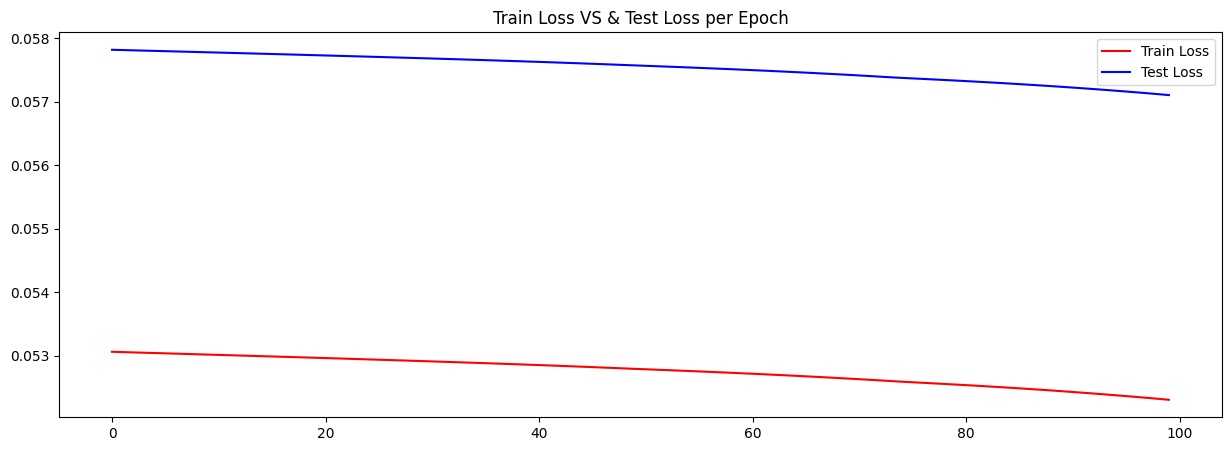

In [23]:
loss_vs_epochs(train_losses_list_1st, test_losses_list_1st)

In [24]:
#Show the results on 5 new sentences.
def show_result(array_of_sentences, model):
  test_sentences_indices = sentences_to_indices(array_of_sentences, word_to_index,len(max(test_sentences, key=len).split()))
  test_sentences_indices = Variable(torch.from_numpy(test_sentences_indices).long())
  outputs = model(test_sentences_indices)
  for i in range(len(array_of_sentences)):
    test_predictive_index = np.argmax(outputs.detach().numpy()[i])
    # print(test_sentences[i], label_to_emoji(test_predictive_index),", the predictions:", [round(x,4) for x in outputs[i].tolist()])
    print(f"#{i+1}  {label_to_emoji(test_predictive_index)}  {array_of_sentences[i]}")

In [25]:
show_result(test_sentences, model_1st)

#1  😄  I love my grandpa
#2  😄  Daniel eat only sushi
#3  😄  I did my homework
#4  😄  my grandpa is sick
#5  😄  kick the ball


# Second model - neural network with RNN

Build a neural network + RNN model that gets the vocabulary size, embedding dimention and pretrained embedding weights, and returns a 5 dimention vector with the scores of every emoji.

Then train the model and plot loss vs. epoch for train and test set.

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

---

You can use the added model as your base model

In [26]:
### START CODE HERE ###
def train_model_3(device, epochs, train_loader, test_loader, model, optimizer, loss_func, train_x_tensor, test_x_tensor):
  
  train_loss_list = []
  train_accuracy_list = []
  test_loss_list = []
  test_accuracy_list = []

  for e in range(epochs):
    train_loss_calc = 0
    test_loss_calc = 0
    train_accuracy_calc = 0
    test_accuracy_calc = 0 

    # model.train()

    for train_inputs, train_labels in train_loader:
      train_inputs = Variable(train_inputs.long())
      train_labels = Variable(train_labels.long())
      optimizer.zero_grad() # Clear the gradients of all optimized variables
      train_h = (Variable(torch.zeros(2,len(train_inputs), 128)),Variable(torch.zeros(2,len(train_inputs), 128)))
      train_outputs = model(train_inputs, train_h) # Forward pass
      loss = loss_func(train_outputs, train_labels) # Calculate the loss
      loss.backward()
      optimizer.step() # Doing the optimizer step
      train_loss_calc += loss.item() # Update running training loss
      model.train() # Actually training the net
      for i in range(len(train_inputs)):
        train_original_index = train_labels[i]
        train_predictive_index = np.argmax(train_outputs[i].detach().numpy())
        if train_original_index == train_predictive_index:
          train_accuracy_calc += 1

    # Update lists  
    train_loss_calc /= len(train_loader.dataset)
    train_accuracy_calc /= len(train_x_tensor)
    train_loss_list.append(train_loss_calc)
    train_accuracy_list.append(train_accuracy_calc)    
      
    # model.eval()
      
    with torch.no_grad():
      for test_input, test_labels in test_loader:
        test_input = Variable(test_input.long())
        test_labels = Variable(test_labels.long())
        test_h = (Variable(torch.zeros(2,len(test_input), 128)),Variable(torch.zeros(2,len(test_input), 128)))
        test_outputs = model(test_input, test_h) # Forward pass
        test_loss_calc += loss_func(test_outputs, test_labels).item() # Update running training loss
        for i in range(len(test_input)):
          test_original_index = test_labels[i]
          test_predictive_index = np.argmax(test_outputs[i].detach().numpy())
          if test_original_index == test_predictive_index:
            test_accuracy_calc += 1

      test_loss_calc /= len(test_loader.dataset)
      test_accuracy_calc /= len(train_x_tensor)
      test_loss_list.append(test_loss_calc)
      test_accuracy_list.append(test_accuracy_calc)      

    if e % 10 == 0:
      print(f"Epoch:{e + 1}/{epochs} \tTrain Loss:{round(train_loss_calc, 5)} \tTrain Accuracy:{round(train_accuracy_calc, 5)} \tTest Loss:{round(test_loss_calc, 5)} \tTest Accuracy:{round(test_accuracy_calc, 5)}")

  return train_loss_list, train_accuracy_list, test_loss_list, test_loss_list

In [27]:
class RNN_Model(nn.Module):
    
    def __init__(self,vocab_size,embedding_dim,pretrained_weight):
        super(RNN_Model,self).__init__()
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim) # stores embeddings of a fixed dictionary and size
        self.word_embeds.weight.data.copy_(torch.from_numpy(pretrained_weight)) # place the pretrained weights to the embedding function
        self.rnn = nn.LSTM(embedding_dim, 128, 2,batch_first = True, dropout = 0.5) 
        self.layers = nn.Sequential(
         nn.Linear(128,64),
         nn.ReLU(),
         nn.Linear(64,32),
         nn.ReLU(),
         nn.Linear(32,10),
         nn.ReLU(),
         nn.Linear(10,5),
         nn.Softmax(dim = 1)
        )

    def forward(self,x,h):
        out = self.word_embeds(x)
        out, _ = self.rnn(out,h)
        out = out[:, -1, :]
        out = self.layers(out)
        return out

In [28]:
model_2nd = RNN_Model(vocabulary_leb_1st, embedding_dim_1st, pretrained_weight_1st)
model_2nd

RNN_Model(
  (word_embeds): Embedding(400001, 50)
  (rnn): LSTM(50, 128, num_layers=2, batch_first=True, dropout=0.5)
  (layers): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=5, bias=True)
    (7): Softmax(dim=1)
  )
)

In [29]:
for param in model_2nd.parameters():
    param.requires_grad = True

In [30]:
optimizer_2nd = torch.optim.Adam(model_2nd.parameters(),lr=0.0001)
loss_func_2nd = torch.nn.CrossEntropyLoss().to(device)

In [31]:
train_losses_list_2nd, train_accuracy_list_2nd, test_losses_list_2nd, test_accuracy_list_2nd = \
train_model_3(device, epochs, train_loader, test_loader, model_2nd, optimizer_2nd, loss_func_2nd, train_data_x_tensor, test_data_x_tensor)

Epoch:1/100 	Train Loss:0.05284 	Train Accuracy:0.18033 	Test Loss:0.05765 	Test Accuracy:0.03825
Epoch:11/100 	Train Loss:0.05274 	Train Accuracy:0.28415 	Test Loss:0.05752 	Test Accuracy:0.08743
Epoch:21/100 	Train Loss:0.05208 	Train Accuracy:0.30601 	Test Loss:0.05661 	Test Accuracy:0.09836
Epoch:31/100 	Train Loss:0.05123 	Train Accuracy:0.30601 	Test Loss:0.05549 	Test Accuracy:0.09836
Epoch:41/100 	Train Loss:0.05109 	Train Accuracy:0.30601 	Test Loss:0.05532 	Test Accuracy:0.09836
Epoch:51/100 	Train Loss:0.05103 	Train Accuracy:0.30601 	Test Loss:0.05526 	Test Accuracy:0.09836
Epoch:61/100 	Train Loss:0.05098 	Train Accuracy:0.30601 	Test Loss:0.0552 	Test Accuracy:0.09836
Epoch:71/100 	Train Loss:0.05092 	Train Accuracy:0.30601 	Test Loss:0.05516 	Test Accuracy:0.09836
Epoch:81/100 	Train Loss:0.05087 	Train Accuracy:0.30601 	Test Loss:0.05511 	Test Accuracy:0.09836
Epoch:91/100 	Train Loss:0.05081 	Train Accuracy:0.30601 	Test Loss:0.05507 	Test Accuracy:0.09836


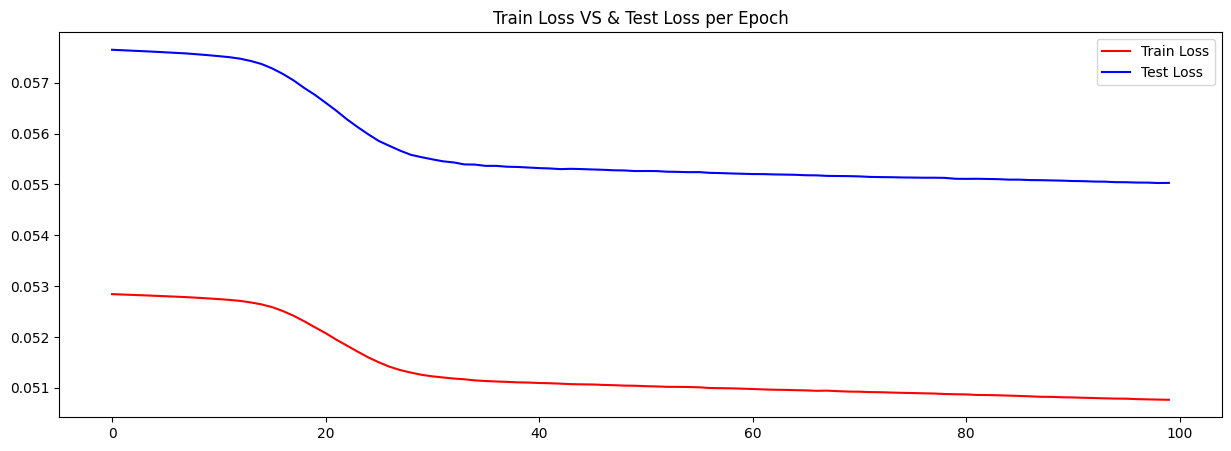

In [32]:
loss_vs_epochs(train_losses_list_2nd, test_losses_list_2nd)

In [33]:
#Show the results on 5 new sentences.
def show_result_2(array_of_sentences, model):
  test_sentences_indices = sentences_to_indices(array_of_sentences, word_to_index, len(max(test_sentences, key=len).split()))
  test_sentences_indices = Variable(torch.from_numpy(test_sentences_indices).long())
  h = (Variable(torch.zeros(2,5,128)),Variable(torch.zeros(2,5,128)))
  outputs = model(test_sentences_indices, h)
  for i in range(len(array_of_sentences)):
    #print(outputs.detach().numpy()[i])
    test_predictive_index = np.argmax(outputs.detach().numpy()[i])
    # print(test_sentences[i], label_to_emoji(test_predictive_index),", the predictions:", [round(x,4) for x in outputs[i].tolist()])
    print(f"#{i+1}  {label_to_emoji(test_predictive_index)}  {array_of_sentences[i]}")

In [34]:
show_result_2(test_sentences, model_2nd)

#1  😄  I love my grandpa
#2  😄  Daniel eat only sushi
#3  😄  I did my homework
#4  😄  my grandpa is sick
#5  😄  kick the ball


# Third model - neural network with transformers

Build a neural network + transformer model that gets the vocabulary size, embedding dimention and pretrained embedding weights, and returns a 5 dimention vector with the scores of every emoji.

Then train the model and plot loss vs. epoch for train and test set.

https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html


---

You can use the added model as your base model

In [35]:
### START CODE HERE ###

In [36]:
import math

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [37]:
class Transformer_model(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pretrained_weight, transformer_dim):
        super(Transformer_model,self).__init__()
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeds.weight.data.copy_(torch.from_numpy(pretrained_weight))
        self.pos_encoding = PositionalEncoding(embedding_dim)
        self.transformer = nn.Transformer(d_model=transformer_dim, nhead=5, num_encoder_layers=6, num_decoder_layers=6)
        self.attention = nn.MultiheadAttention(embed_dim=transformer_dim, num_heads=5)
        self.embeds_to_transformer = nn.Linear(embedding_dim, transformer_dim)
        self.layers = nn.Sequential(
            nn.Linear(transformer_dim, transformer_dim//2),
            nn.ReLU(),
            nn.Linear(transformer_dim//2,transformer_dim//4),
            nn.ReLU(),
            nn.Linear(transformer_dim//4, transformer_dim//6),
            nn.ReLU(),
            nn.Linear(transformer_dim//6 ,5),
            nn.Softmax(dim = 1)
        )
        
    def forward(self,x):
        out = self.word_embeds(x)
        out += self.pos_encoding(out)
        out = self.embeds_to_transformer(out)
        out = self.transformer(out, out)
        out = torch.sum(out, axis = 1)
        out = self.layers(out)
        return out



In [38]:
transformer_dim = 100

In [39]:
model_3rd = Transformer_model(vocabulary_leb_1st, embedding_dim_1st, pretrained_weight_1st, transformer_dim)
model_3rd

Transformer_model(
  (word_embeds): Embedding(400001, 50)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
          )
          (linear1): Linear(in_features=100, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=100, bias=True)
          (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): N

In [40]:
optimizer_3rd = torch.optim.Adam(model_3rd.parameters(),lr=0.0001)
loss_func_3rd = torch.nn.CrossEntropyLoss().to(device)

In [41]:
train_losses_list_3rd, train_accuracy_list_3rd, test_losses_list_3rd, test_accuracy_list_3rd = \
train_model_2(device, epochs, train_loader, test_loader, model_3rd, optimizer_3rd, loss_func_3rd, train_data_x_tensor, test_data_x_tensor)

Epoch:1/100 	Train Loss:0.05165 	Train Accuracy:0.30055 	Test Loss:0.0555 	Test Accuracy:0.09836
Epoch:11/100 	Train Loss:0.05067 	Train Accuracy:0.30601 	Test Loss:0.05504 	Test Accuracy:0.0929
Epoch:21/100 	Train Loss:0.04788 	Train Accuracy:0.43716 	Test Loss:0.05535 	Test Accuracy:0.10383
Epoch:31/100 	Train Loss:0.04625 	Train Accuracy:0.5082 	Test Loss:0.05413 	Test Accuracy:0.11475
Epoch:41/100 	Train Loss:0.04531 	Train Accuracy:0.53005 	Test Loss:0.05392 	Test Accuracy:0.11475
Epoch:51/100 	Train Loss:0.04373 	Train Accuracy:0.56831 	Test Loss:0.05293 	Test Accuracy:0.11475
Epoch:61/100 	Train Loss:0.04255 	Train Accuracy:0.5847 	Test Loss:0.05265 	Test Accuracy:0.13115
Epoch:71/100 	Train Loss:0.04069 	Train Accuracy:0.69399 	Test Loss:0.05271 	Test Accuracy:0.10929
Epoch:81/100 	Train Loss:0.0397 	Train Accuracy:0.71585 	Test Loss:0.05114 	Test Accuracy:0.14208
Epoch:91/100 	Train Loss:0.03874 	Train Accuracy:0.72678 	Test Loss:0.05414 	Test Accuracy:0.10383


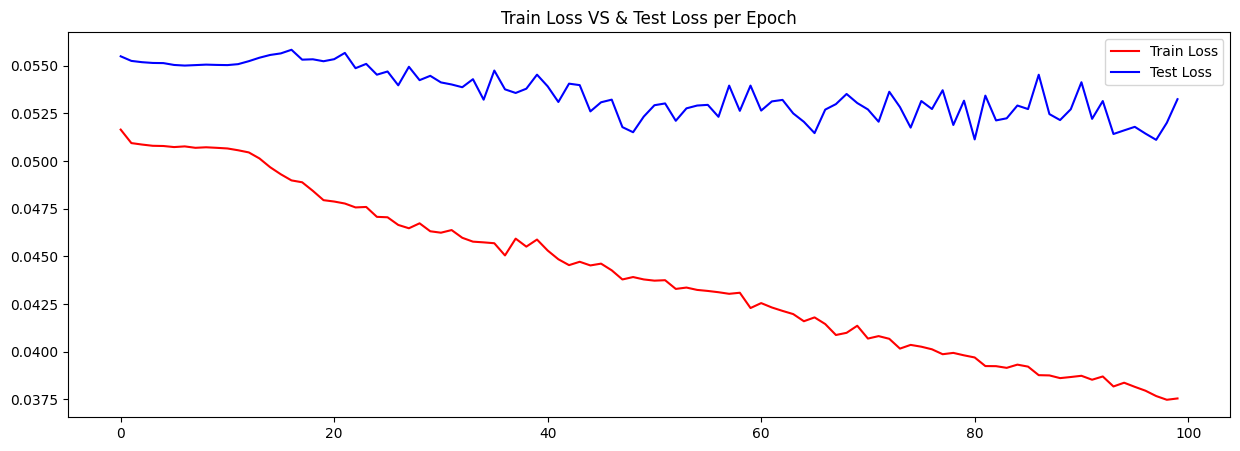

In [42]:
loss_vs_epochs(train_losses_list_3rd, test_losses_list_3rd)

In [43]:
show_result(test_sentences, model_3rd)

#1  ❤️  I love my grandpa
#2  ❤️  Daniel eat only sushi
#3  😞  I did my homework
#4  😞  my grandpa is sick
#5  😄  kick the ball


### Compare between the models - who had the best results? Try to explain why. 

Write your answere here